In [44]:
import numpy as np
import torch

In [108]:
n=int(1e4)
d=3
k=1

In [109]:
data = torch.randn((n, k+1))
norms = torch.linalg.norm(data, dim=1)
data = data / norms[:,None]

In [111]:
# random isometric embedding
embedding_matrix = torch.randn((d, k+1))
q, r = np.linalg.qr(embedding_matrix)
q = torch.from_numpy(q)

In [112]:
embedded_data = (q @ data.T).T

In [113]:
embedded_data.shape

torch.Size([10000, 3])

In [114]:
from matplotlib import pyplot as plt

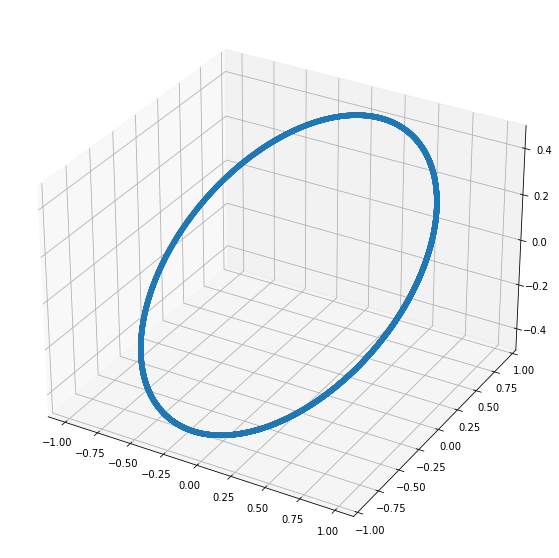

In [115]:
plt_data = embedded_data.numpy()
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='3d'))
ax.scatter(plt_data[:,0], plt_data[:,1], plt_data[:,2])
fig.show()